# Machine Unlearning: Retraining and Scrubbing in a K9db-Integrated System
Final Project for DS 593 Fall 2025
Tracy Cui, Yuki Li, Yang Lu, Xin Wei

## Code Notebook 1: Deletion with Random User-Sample Pairing

Running on device: cuda
Loading MNIST...


100%|██████████| 9.91M/9.91M [00:00<00:00, 20.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 507kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.66MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.99MB/s]


Top User: 24748 images

--- [Phase 1] Generating Table 1 ---
Training Base Model (M0)...
Running Retrain Benchmark (M0)...
Running Fisher Scrub (M2)...

+------------------+---------------------+---------------------+
| Metric           | Full Retrain (M0)   |   Fisher Scrub (M2) |
+==================+=====================+=====================+
| Retain Acc (%)   | 98.47               |               91.61 |
+------------------+---------------------+---------------------+
| Forget Acc (%)   | 96.90               |               91.03 |
+------------------+---------------------+---------------------+
| Weight Dist (L2) | 0.0 (Ref)           |               39.37 |
+------------------+---------------------+---------------------+
| Runtime (s)      | 36.37               |                1.53 |
+------------------+---------------------+---------------------+

--- [Phase 2] Fig 1: Scalability ---

--- [Phase 3] Fig 2: Deletion Amount ---

--- [Phase 4] Fig 3: Zipfian Top-K Users ---

[Done

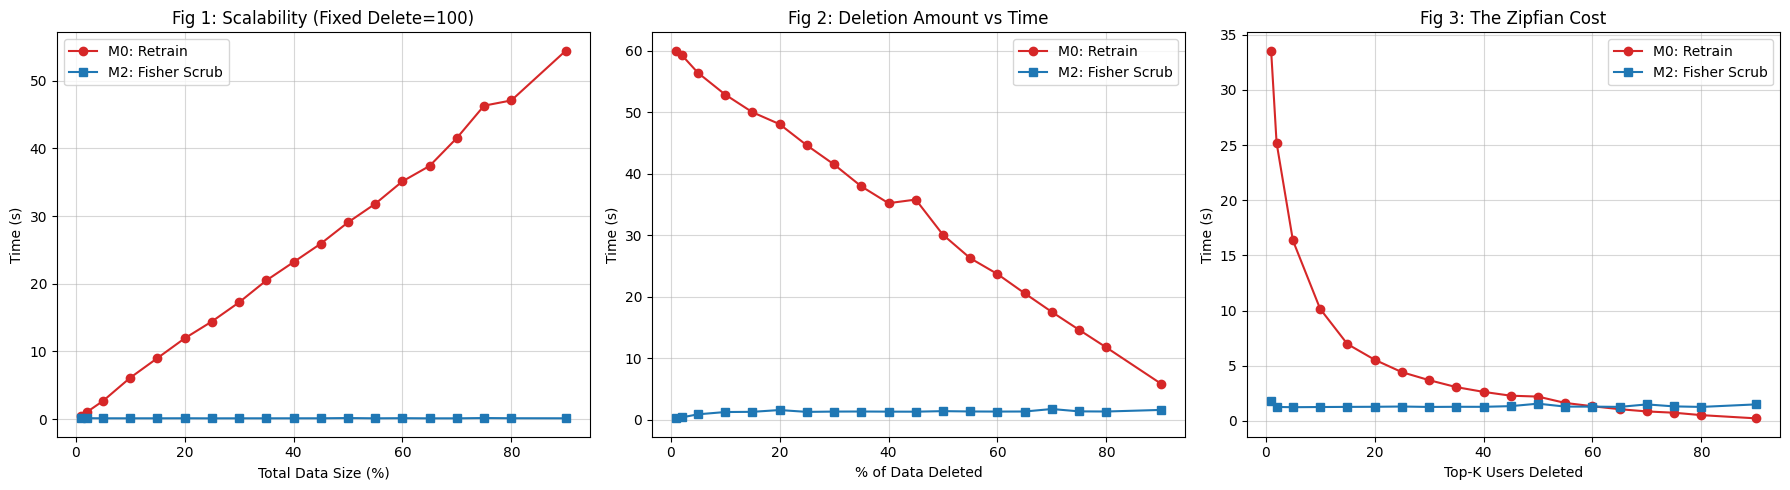

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
from tabulate import tabulate

# ==========================================
# 1. Model configrations 
# ==========================================

CONFIG = {
    "batch_size": 128,
    "lr": 0.01,
    "epochs_m0": 5,

    # FISHER SCRUBBING PARAMS
    "unlearn_epochs": 1,

    # CHANGE 1: The "Geometric Mean" LR
    # fine-tuned; 0.001 was too weak. 0.005 was too strong.
    "unlearn_lr": 0.002,

    "fisher_samples": 500,

    "alpha": 1.0,

    # relatively big scrub steps to preserve accuracy 
    "max_scrub_steps": 50,

    "total_users": 100,
    "zipf_param": 1.5,
    "seed": 42,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu")
}


torch.manual_seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])
print(f"Running on device: {CONFIG['device']}") # so we know we're running on GPU 

# ==========================================
# 2. Model Helper (we used a simple MLP)
# ==========================================

class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        # MNIST is 28x28 = 784 inputs
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# ==========================================
# 3. FISHER SCRUBBING HELPERs
# ==========================================
def compute_fisher_diagonal(model, loader, num_samples=500):

    # here we stimated the diagonal of the Fisher Information Matrix.
    # This tells us which weights are important for the Retain Set.

    fisher_diag = {}
    for name, param in model.named_parameters():
        fisher_diag[name] = torch.zeros_like(param)

    model.eval()
    criterion = nn.CrossEntropyLoss()
    samples_seen = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(CONFIG["device"]), labels.to(CONFIG["device"])
        model.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        for name, param in model.named_parameters():
            if param.grad is not None:

                # Accumulate squared gradients
                fisher_diag[name] += param.grad.data ** 2

        samples_seen += inputs.size(0)
        if samples_seen >= num_samples:
            break

    # Normalize the calculated values 
    for name in fisher_diag:
        fisher_diag[name] /= samples_seen

    return fisher_diag


def fisher_scrubbing_step(model, inputs, labels, fisher_diag):
    model.train()
    model.zero_grad()

    # Minimize KL Divergence to Uniform

    # 1. Log Softmax for KL Divergence 
    outputs = F.log_softmax(model(inputs), dim=1)

    # 2. Create Target: Uniform Distribution (Complete Confusion)
    # We want the model to output [0.1, 0.1, ..., 0.1] for the forget set
    # 0.1 is because we have 10 distinct classes -- digits 0 to 9

    batch_size = inputs.size(0)
    num_classes = 10
    uniform_target = torch.full((batch_size, num_classes), 1.0 / num_classes).to(CONFIG["device"])

    # 3. Calculate Loss: Distance to Uniformity
    criterion = nn.KLDivLoss(reduction='batchmean')
    loss = criterion(outputs, uniform_target)

    # 4. Backward (Minimize this distance)
    loss.backward()

    # 5. Update with Fisher Constraint

    with torch.no_grad():
        for name, param in model.named_parameters():
            if param.grad is not None:
                F_ii = fisher_diag[name]

                # Scale: High Fisher Info means Small Step
                # therefore important information does not get replaced by random noises 
                scale = 1.0 / (F_ii + CONFIG["alpha"])

                # do subtraction because we are Minimizing KL divergence (Descent)
                update = CONFIG["unlearn_lr"] * scale * param.grad

                # Safety Clamp
                update.clamp_(min=-0.05, max=0.05)

                param.sub_(update)

# ==========================================
# 4. Helper functions for running and evaluating the models 
# ==========================================

def run_training(model, loader, epochs):
    optimizer = optim.SGD(model.parameters(), lr=CONFIG["lr"], momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    model.train()
    for _ in range(epochs):
        for inputs, labels in loader:
            inputs, labels = inputs.to(CONFIG["device"]), labels.to(CONFIG["device"])
            optimizer.zero_grad()
            loss = criterion(model(inputs), labels)
            loss.backward()
            optimizer.step()

def evaluate(model, loader):
    model.eval()
    correct = 0; total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(CONFIG["device"]), labels.to(CONFIG["device"])
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    if total == 0: return 0.0
    return (100 * correct / total)

def get_model_dist(model_a, model_b):
    dist = 0.0
    for p1, p2 in zip(model_a.parameters(), model_b.parameters()):
        dist += torch.norm(p1 - p2, p=2).item()
    return dist

# ==========================================
# 5. DATA SETUP (MNIST + ZIPF)
# ==========================================

print("Loading MNIST...")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # MNIST Mean/Std
])

# download the data 
full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Zipfian Distribution for Users
# Note that this is not an artifically created example
# MNIST itself is equally weighted access outcomes, and therefore we're creating a re-weighting to mimic the data distribution we might see for a, for example, social media platform dataset. 

ranks = np.arange(1, CONFIG["total_users"] + 1)
weights = 1 / np.power(ranks, CONFIG["zipf_param"]) # artifical weights
weights /= weights.sum()
user_counts = np.random.multinomial(len(full_dataset), weights)
user_counts = np.sort(user_counts)[::-1]

data_map = {}
curr_idx = 0
for i, count in enumerate(user_counts):
    data_map[i] = list(range(curr_idx, curr_idx + count))
    curr_idx += count

print(f"Top User: {user_counts[0]} images")

# ==========================================
# 6. Results Table 1
# ==========================================
print("\n--- [Phase 1] Generating Table 1 ---")

# Base Training
base_loader = DataLoader(full_dataset, batch_size=CONFIG["batch_size"], shuffle=True)
base_model = SimpleMLP().to(CONFIG["device"])
print("Training Base Model (M0)...")
run_training(base_model, base_loader, CONFIG["epochs_m0"])

# Setup Split (User 0 is Target)
target_user = 0
forget_idx = data_map[target_user]
retain_idx = [i for i in range(len(full_dataset)) if i not in forget_idx]

retain_loader = DataLoader(Subset(full_dataset, retain_idx), batch_size=CONFIG["batch_size"], shuffle=True)
forget_loader = DataLoader(Subset(full_dataset, forget_idx), batch_size=CONFIG["batch_size"], shuffle=True)

# M0: Full Retrain (Gold Standard)
print("Running Retrain Benchmark (M0)...")
start = time.time()
m0_model = SimpleMLP().to(CONFIG["device"])
run_training(m0_model, retain_loader, CONFIG["epochs_m0"])
time_m0 = time.time() - start

# M2: Fisher Scrubbing
print("Running Fisher Scrub (M2)...")
start = time.time()
m2_model = copy.deepcopy(base_model)
fisher_diag = compute_fisher_diagonal(m2_model, retain_loader, CONFIG["fisher_samples"])

scrub_steps = 0
for _ in range(CONFIG["unlearn_epochs"]):
    for inputs, labels in forget_loader:
        fisher_scrubbing_step(m2_model, inputs.to(CONFIG["device"]), labels.to(CONFIG["device"]), fisher_diag)
        scrub_steps += 1
        if scrub_steps >= CONFIG["max_scrub_steps"]:
            break
    if scrub_steps >= CONFIG["max_scrub_steps"]:
        break
time_m2 = time.time() - start

# Metrics
acc_m0_r = evaluate(m0_model, retain_loader)
acc_m2_r = evaluate(m2_model, retain_loader)
acc_m0_f = evaluate(m0_model, forget_loader)
acc_m2_f = evaluate(m2_model, forget_loader)
w_dist = get_model_dist(m0_model, m2_model)

table_data = [
    ["Metric", "Full Retrain (M0)", "Fisher Scrub (M2)"],
    ["Retain Acc (%)", f"{acc_m0_r:.2f}", f"{acc_m2_r:.2f}"],
    ["Forget Acc (%)", f"{acc_m0_f:.2f}", f"{acc_m2_f:.2f}"],
    ["Weight Dist (L2)", "0.0 (Ref)", f"{w_dist:.2f}"],
    ["Runtime (s)", f"{time_m0:.2f}", f"{time_m2:.2f}"]
]
print("\n" + tabulate(table_data, headers="firstrow", tablefmt="grid"))

# ==========================================
# 7. EXPERIMENT 1: SCALABILITY (Total Size vs Time)
# ==========================================

print("\n--- [Phase 2] Fig 1: Scalability ---")
percents = [1, 2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 90]
exp1_m0 = []
exp1_m2 = []
FIXED_DEL = 100 # Fixed number of images to forget; measure time. 

for p in percents:
    subset_len = int(len(full_dataset) * (p/100))
    indices = np.random.choice(len(full_dataset), subset_len, replace=False)

    # Ensure we have enough data to split
    if subset_len <= FIXED_DEL: continue

    r_idx = indices[FIXED_DEL:]
    f_idx = indices[:FIXED_DEL]

    r_loader_sub = DataLoader(Subset(full_dataset, r_idx), batch_size=CONFIG["batch_size"])
    f_loader_sub = DataLoader(Subset(full_dataset, f_idx), batch_size=CONFIG["batch_size"])

    # M0 Time
    s = time.time()
    run_training(SimpleMLP().to(CONFIG["device"]), r_loader_sub, CONFIG["epochs_m0"])
    exp1_m0.append(time.time() - s)

    # M2 Time
    s = time.time()
    temp_m2 = copy.deepcopy(base_model)
    fd = compute_fisher_diagonal(temp_m2, r_loader_sub, CONFIG["fisher_samples"])

    steps = 0
    for x, y in f_loader_sub:
        fisher_scrubbing_step(temp_m2, x.to(CONFIG["device"]), y.to(CONFIG["device"]), fd)
        steps += 1
        if steps >= CONFIG["max_scrub_steps"]: break

    exp1_m2.append(time.time() - s)

# ==========================================
# 8. EXPERIMENT 2: DELETE PERCENTAGE
# ==========================================
print("\n--- [Phase 3] Fig 2: Deletion Amount ---")
del_percents = [1, 2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 90]

exp2_m0 = []
exp2_m2 = []

# Shuffle full dataset indices for random deletion
indices = np.arange(len(full_dataset))
np.random.shuffle(indices)

for p in del_percents:
    n_forget = int(len(full_dataset) * (p/100))
    if n_forget == 0: continue

    f_idx = indices[:n_forget]
    r_idx = indices[n_forget:]

    r_loader_sub = DataLoader(Subset(full_dataset, r_idx), batch_size=CONFIG["batch_size"])
    f_loader_sub = DataLoader(Subset(full_dataset, f_idx), batch_size=CONFIG["batch_size"])

    # M0
    s = time.time()
    run_training(SimpleMLP().to(CONFIG["device"]), r_loader_sub, CONFIG["epochs_m0"])
    exp2_m0.append(time.time() - s)

    # M2
    s = time.time()
    temp_m2 = copy.deepcopy(base_model)
    fd = compute_fisher_diagonal(temp_m2, r_loader_sub, CONFIG["fisher_samples"])

    steps = 0
    # Note: For large forget sets, we might hit max_steps early, which is fine
    for x, y in f_loader_sub:
        fisher_scrubbing_step(temp_m2, x.to(CONFIG["device"]), y.to(CONFIG["device"]), fd)
        steps += 1
        if steps >= CONFIG["max_scrub_steps"]: break

    exp2_m2.append(time.time() - s)

# ==========================================
# 9. EXPERIMENT 3: ZIPFIAN USERS
# ==========================================
print("\n--- [Phase 4] Fig 3: Zipfian Top-K Users ---")
# k_vals = [1, 2, 5, 10, 20, 30, 50] # was not able to find a crossing point as we discussed in Kinan's office hour; had to increase the max of k to find it. 
# takeaway: retraining (M0) is almost always more expensive
k_vals = [1, 2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 90]
exp3_m0 = []
exp3_m2 = []

for k in k_vals:
    # Identify indices
    forget_indices = []
    for u in range(k):
        forget_indices.extend(data_map[u])

    retain_indices = [i for i in range(len(full_dataset)) if i not in forget_indices]

    r_loader_sub = DataLoader(Subset(full_dataset, retain_indices), batch_size=CONFIG["batch_size"])
    f_loader_sub = DataLoader(Subset(full_dataset, forget_indices), batch_size=CONFIG["batch_size"])

    # M0
    s = time.time()
    run_training(SimpleMLP().to(CONFIG["device"]), r_loader_sub, CONFIG["epochs_m0"])
    exp3_m0.append(time.time() - s)

    # M2
    s = time.time()
    temp_m2 = copy.deepcopy(base_model)
    fd = compute_fisher_diagonal(temp_m2, r_loader_sub, CONFIG["fisher_samples"])

    steps = 0
    for x, y in f_loader_sub:
        fisher_scrubbing_step(temp_m2, x.to(CONFIG["device"]), y.to(CONFIG["device"]), fd)
        steps += 1
        if steps >= CONFIG["max_scrub_steps"]: break

    exp3_m2.append(time.time() - s)

# ==========================================
# 10. PLOTTING
# ==========================================
plt.figure(figsize=(18, 5))

# Plot 1
plt.subplot(1, 3, 1)
plt.plot(percents, exp1_m0, 'o-', label="M0: Retrain", color='#d62728')
plt.plot(percents, exp1_m2, 's-', label="M2: Fisher Scrub", color='#1f77b4')
plt.xlabel("Total Data Size (%)")
plt.ylabel("Time (s)")
plt.title("Fig 1: Scalability (Fixed Delete=100)")
plt.legend()
plt.grid(True, alpha=0.5)

# Plot 2
plt.subplot(1, 3, 2)
plt.plot(del_percents, exp2_m0, 'o-', label="M0: Retrain", color='#d62728')
plt.plot(del_percents, exp2_m2, 's-', label="M2: Fisher Scrub", color='#1f77b4')
plt.xlabel("% of Data Deleted")
plt.ylabel("Time (s)")
plt.title("Fig 2: Deletion Amount vs Time")
plt.legend()
plt.grid(True, alpha=0.5)

# Plot 3
plt.subplot(1, 3, 3)
plt.plot(k_vals, exp3_m0, 'o-', label="M0: Retrain", color='#d62728')
plt.plot(k_vals, exp3_m2, 's-', label="M2: Fisher Scrub", color='#1f77b4')
plt.xlabel("Top-K Users Deleted")
plt.ylabel("Time (s)")
plt.title("Fig 3: The Zipfian Cost")
plt.legend()
plt.grid(True, alpha=0.5)

plt.tight_layout()
plt.savefig("fisher_scrubbing_analysis.png")
print("\n[Done] Analysis saved to 'fisher_scrubbing_analysis.png'")